In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
import PIL

!pip install -qU livelossplot
!pip install -qU torchmetrics

from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchmetrics import MeanMetric
from livelossplot import PlotLosses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.3 MB/s eta 0:00:00


### Download the dataset

In [2]:
# final set
# https://drive.google.com/file/d/1rRmNRQgSW3k09B76AAi5LfGztRSDOXVf/view
if not os.path.exists('document_dataset_resized'):
  !gdown 1rRmNRQgSW3k09B76AAi5LfGztRSDOXVf
  !unzip -qq './document_dataset_resized.zip'
else:
  print("Data Already Downloaded")

Downloading...
From: https://drive.google.com/uc?id=1rRmNRQgSW3k09B76AAi5LfGztRSDOXVf
To: /content/document_dataset_resized.zip
100% 1.50G/1.50G [00:18<00:00, 79.6MB/s]


In [3]:
# Set the random seed for reproducibility
def reproducibility(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

num_seed = 42
reproducibility(num_seed)

In [4]:
# Declare data location & file location for model weights
data_location = r"./document_dataset_resized"
bestmodel_path = r"Mobilev3Model.pth" 

img_size = 384
num_workers = 2

### Data Preparation

In [5]:
def train_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomGrayscale(p=0.4),                                        
        transforms.Normalize(mean, std),
    ])
    return transform


def valid_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return transform


class SegDataset(Dataset):
    def __init__(self, *, img_paths, mask_paths, image_size=(384, 384), data_type="train"):
        self.data_type = data_type
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.image_size = image_size

        if self.data_type == "train":
            self.transform = train_transforms()
        else:
            self.transform = valid_transforms()

    def read_file(self, path):
        file = cv2.imread(path)[:, :, ::-1]
        file = cv2.resize(file, 
                          self.image_size, interpolation=cv2.INTER_NEAREST)
        return file

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        image_path = self.img_paths[index]
        image = self.read_file(image_path)
        image = self.transform(image)

        mask_path = self.mask_paths[index]
        
        gt_mask = self.read_file(mask_path).astype(np.int32)

        _mask = np.zeros((*self.image_size, 2), dtype=np.float32)
        
	      # Mask Background
        _mask[:, :, 0] = np.where(gt_mask[:, :, 0] == 0, 1.0, 0.0) 
	      # Mask Document
        _mask[:, :, 1] = np.where(gt_mask[:, :, 0] == 255, 1.0, 0.0)  

        mask = torch.from_numpy(_mask).permute(2, 0, 1)

        return image, mask


In [6]:
def get_dataset(data_location, batch_size=16):
    # Train dataset location
    trainimg_loc = os.path.join(data_location, "train", "images")
    trainmsk_loc = os.path.join(data_location, "train", "masks")

    # Validation dataset location
    validimg_loc = os.path.join(data_location, "valid", "images")
    validmsk_loc = os.path.join(data_location, "valid", "masks")
 
    # Accessing train & validation image, mask dataset
    trainimg_paths = [os.path.join(trainimg_loc, i) for i in os.listdir(trainimg_loc)] 
    trainmsk_paths = [os.path.join(trainmsk_loc, i) for i in os.listdir(trainmsk_loc)]

    validimg_paths = [os.path.join(validimg_loc, i) for i in os.listdir(validimg_loc)]
    validmsk_paths = [os.path.join(validmsk_loc, i) for i in os.listdir(validmsk_loc)]

    train_ds = SegDataset(img_paths=trainimg_paths, mask_paths=trainmsk_paths, data_type="train")
    valid_ds = SegDataset(img_paths=validimg_paths, mask_paths=validmsk_paths, data_type="valid")

    # Make dataloader for train & validation image mask dataset
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True,  pin_memory=True)
    val_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)

    return train_loader, val_loader

In [7]:
train_loader, val_loader = get_dataset(data_location, batch_size=1)

See the size and type of images & mask in val_loader

In [8]:
for i, j in val_loader:
    print(i.shape, j.shape, j.dtype)
    break

torch.Size([1, 3, 384, 384]) torch.Size([1, 2, 384, 384]) torch.float32


Make Denormalize Function to image tensors for Show the image

In [9]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0., max=1.)

Show the image sample on val_lodaer with background & document mask

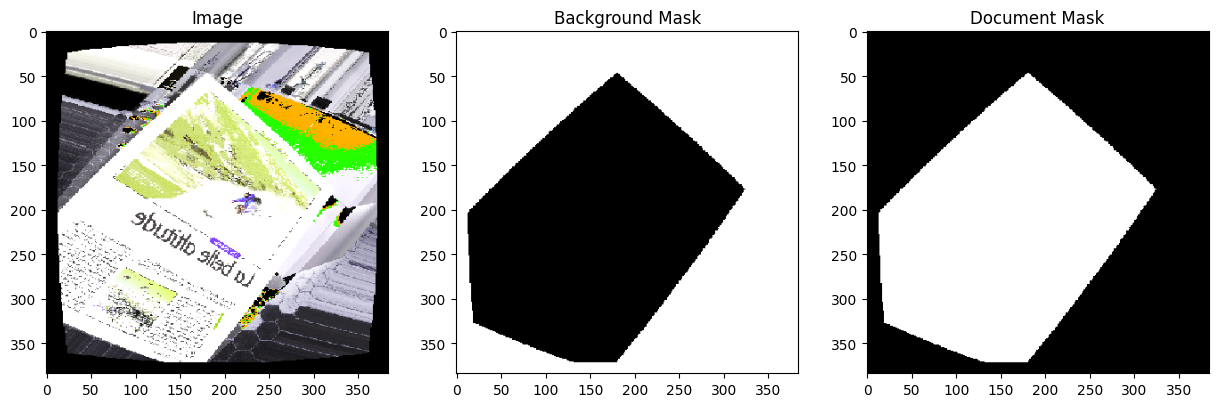

In [10]:
for image, mask in val_loader:
    image = denormalize(image)
    image = image[0]
    plt.figure(figsize=(15, 5))
    
    # Image
    plt.subplot(1, 3, 1)
    x = image.permute(1, 2, 0).numpy()
    plt.imshow(x)
    plt.title('Image')
    
    labels = mask[0]
    # Background Mask
    plt.subplot(1, 3, 2)
    plt.imshow(labels[0].numpy(), cmap='gray')
    plt.title("Background Mask")
    # Document Mask
    plt.subplot(1, 3, 3)
    plt.imshow(labels[1].numpy(), cmap='gray')
    plt.title("Document Mask")
    
    plt.show()        

    break

### Create Model for Document Segmentation

In [11]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

def prepare_model(backbone_model="MobileNetv3", num_classes=2):
    weights = 'DEFAULT'
    if backbone_model == "MobileNetv3":
      model = deeplabv3_mobilenet_v3_large(weights=weights)
    else:
      raise ValueError("Wrong backbone model passed. Must be 'MobileNetv3'")

    # Will update number of output channels for the output layer & remove pretrained weights on last layer
    model.classifier[4]     = nn.LazyConv2d(num_classes, 1)
    model.aux_classifier[4] = nn.LazyConv2d(num_classes, 1)
    return model

Test train model with random tensor

In [12]:
model = prepare_model(num_classes=2)

out = model(torch.randn(2, 3, 384, 384))
out['out'].shape

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:01<00:00, 42.3MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 2, 384, 384])

### Make Loss and Metric Class

In [13]:
def metric_calculation(predictions, targets, use_dice=False, smooth=1e-6, dims=(2, 3)):
    intersection = (predictions * targets).sum(dim=dims) + smooth 
    summation = (predictions.sum(dim=dims) + targets.sum(dim=dims)) + smooth 
        
    if use_dice:
        metric = (2.0 * intersection) / summation
    else:
        union = summation - intersection
        metric = intersection /  union
   
    total = metric.mean()
    
    return total

Loss Class for count the total loss of model (using BCE & IoU)

In [14]:
class Loss(nn.Module):
    def __init__(self, smooth=1e-6, use_dice=False):
        super().__init__()
        self.smooth = smooth
        self.use_dice = use_dice

    def forward(self, predictions, targets):
        # Normalize model predictions
        predictions = torch.sigmoid(predictions)

        # Calculate pixel-wise loss for both channels.
        pixel_loss = F.binary_cross_entropy(predictions, targets, reduction="mean")
        mask_loss  = 1 - metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)
        total_loss = mask_loss + pixel_loss
        
        return total_loss

Metric Class for count evaluation metric (IoU / Dice(F1-Score))

In [15]:
def convert_onehot(matrix, num_classes=3):
    matrix = matrix.permute(0, 2, 3, 1)
    matrix = torch.argmax(matrix, dim=-1)
    matrix = torch.nn.functional.one_hot(matrix, num_classes=num_classes)
    matrix = matrix.permute(0, 3, 1, 2)

    return matrix

class Metric(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6, use_dice=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth      = smooth
        self.use_dice    = use_dice
    
    def forward(self, predictions, targets):
        predictions = convert_onehot(predictions, num_classes=self.num_classes)
        metric = metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)
        
        return metric

### Make function for move model & class for move training and validation loader to device

In [16]:
def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

### Train Model Processing Function

In [17]:
def step(model, epoch_num=None, loader=None, optimizer_fn=None, loss_fn=None, metric_fn=None, is_train=False, metric_name="iou"):

    loss_record   = MeanMetric()
    metric_record = MeanMetric()
    
    loader_len = len(loader)

    text = "Train" if is_train else "Valid"

    for data in tqdm(iterable=loader, total=loader_len, dynamic_ncols=True, desc=f"{text} :: Epoch: {epoch_num}"):
        
        if is_train:
            preds = model(data[0])["out"]
        else:
            with torch.inference_mode():
                preds = model(data[0])["out"].detach()

        loss = loss_fn(preds, data[1])

        if is_train:
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

        metric = metric_fn(preds.detach(), data[1])

        loss_value = loss.detach().item()
        metric_value = metric.detach().item()
        
        loss_record.update(loss_value)
        metric_record.update(metric_value)

    current_loss   = loss_record.compute()
    current_metric = metric_record.compute()

    return current_loss, current_metric

### Let's train the model

In [18]:
epochs = 15
batch_size = 64
num_classes = 2

device = get_default_device()

backbone_model_name = "MobileNetv3"

model = prepare_model(backbone_model=backbone_model_name, num_classes=num_classes)
model.to(device)

# Dummy pass through the model
_ = model(torch.randn((2, 3, 384, 384), device=device))


train_loader, valid_loader = get_dataset(data_location=data_location, batch_size=batch_size)
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

metric_name = "iou"
use_dice = True if metric_name == "dice" else False 

metric_fn = Metric(num_classes=num_classes, use_dice=use_dice).to(device)
loss_fn   = Loss(use_dice=use_dice).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

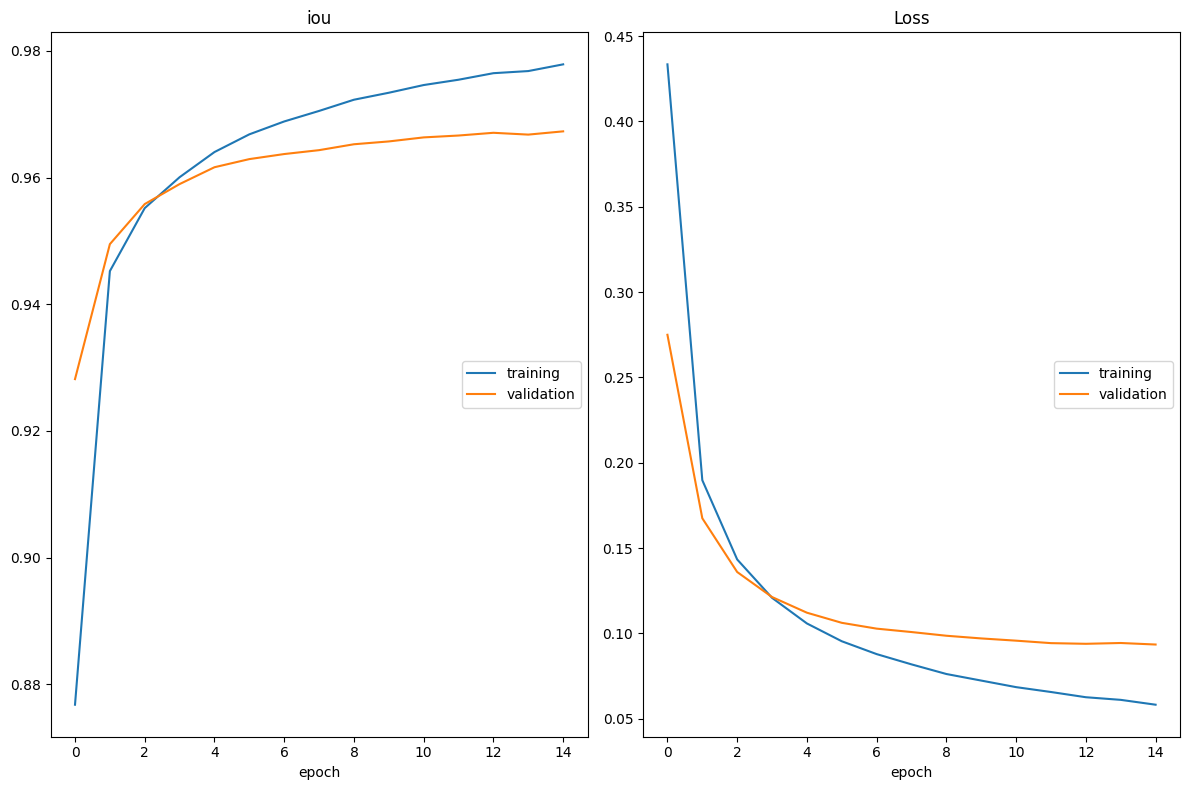

iou
	training         	 (min:    0.877, max:    0.978, cur:    0.978)
	validation       	 (min:    0.928, max:    0.967, cur:    0.967)
Loss
	training         	 (min:    0.058, max:    0.433, cur:    0.058)
	validation       	 (min:    0.094, max:    0.275, cur:    0.094)

Saving model.....


In [19]:
liveloss = PlotLosses()  
best_metric = 0.0

for epoch in range(1, epochs + 1):

    logs = {}
    # Training
    model.train()
    train_loss, train_metric = step(model, 
                                    epoch_num=epoch, 
                                    loader=train_loader, 
                                    optimizer_fn=optimizer, 
                                    loss_fn=loss_fn, 
                                    metric_fn=metric_fn, 
                                    is_train=True,
                                    metric_name=metric_name,
                                    )
    # Evaluation
    model.eval()
    valid_loss, valid_metric = step(model, 
                                    epoch_num=epoch, 
                                    loader=valid_loader, 
                                    loss_fn=loss_fn, 
                                    metric_fn=metric_fn, 
                                    is_train=False,
                                    metric_name=metric_name,
                                    )

    logs['loss']               = train_loss
    logs[metric_name]          = train_metric
    logs['val_loss']           = valid_loss
    logs[f'val_{metric_name}'] = valid_metric

    liveloss.update(logs)
    liveloss.send()

    if valid_metric >= best_metric:
        print("\nSaving model.....")
        torch.save(model.state_dict(), bestmodel_path)
        best_metric = valid_metric